In [1]:
import argparse
import yaml
from tqdm import tqdm
import sys
import copy

import pickle

import jax
import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

use_newplot = False


from helpers.data import get_pdf_toy_JAX, read_in_data_JAX

# Params and Initialization

### @RADHA, IMPORTANT CHANGE

I made it so mstar is the lowest power of alpha that can appear in either g_star or g_mn.

If mstar = 1, then the 0th row of both matrices correspond to alpha^1 terms.

If mstar = 0, then the 0th row of both matrices correspond to alpha^0 terms. 

Look at `utils.distribution_utils.build_q_mstar`to see how this works. 

In [ ]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 2
n = 7
dist = "thrust"

mult_factor = 2 if dist == "thrust" else 1



random_init = True # for radha
zero_error_scale = 1.0 # Fraction of minimum error to set error on 0, default is 1
lr = 0.00100
weight_decay = 0.001
epochs = 50000
batch_size = 320*1
seed = 42
freeze_previous_order = True   # NEW
bogo_init = True
random_batch = False

name = f"{dist}_m{m}_n{n}"
init_from = f"{dist}_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)
jax_key, key1, key2, key3, key4, key5, key6, key7 = jax.random.split(jax_key, 8)

# Colors
colors = ["red", "violet", "blue"][::-1]
darkcolors = ["darkred", "darkviolet", "darkblue"][::-1]


# Initialize params
params = {
    "g_star" : -np.zeros((m+1 - mstar, n+1)),
    "g_coeffs" : -np.zeros((m+1 - mstar, n+1)),
    "thetas" : np.zeros((m+1 - mstar,)) ,
    "thetas_coeffs" : np.zeros((m+1 - mstar,)) ,
    "betas" : 1 * np.ones((m+1 - mstar,)),
    "betas_coeffs" : 1 * np.ones((m+1 - mstar,)),
    "betas_positive" : 1 * np.ones((m+1 - mstar,)),
}

beta_limits = [1.0, 25]


factorials = np.ones_like(params["g_star"])
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)




# # For flavor, slightly smarter inits
signs = (-1) * np.power(-1, np.arange(n + 1) % 2)
# params["g_star"][0,0] = -1
params["g_star"][0,1] = -1
params["g_coeffs"][0,1] = 0
params["thetas"][0] = 0.5
if m == 2:
    params["thetas_coeffs"][0] = 0
    params["thetas"][1] = -0
    # params["g_star"][1,2] = 0


# Decent sign initialization
for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs #* factorials[mi]
    params["g_coeffs"][mi] *= signs #* factorials[mi]


params_0 = copy.deepcopy(params)

if random_init:

    # Initialize params
    params = {
        "g_star" : np.array(-jnp.abs(jax.random.normal(key1, shape = params["g_star"].shape) * 0.1)),
        "g_coeffs" : np.array(-jnp.abs(jax.random.normal(key2, shape = params["g_star"].shape) * 0.1)),
        "thetas" : np.array(jax.random.uniform(key3, shape = (m+1 - mstar,))) ,
        "thetas_coeffs" : np.array(jax.random.uniform(key4, shape = (m+1 - mstar,))) ,
        "betas" : np.array(1 + jax.random.uniform(key5, shape = (m+1 - mstar,))),
        "betas_coeffs" : np.array(1 + jax.random.uniform(key6, shape = (m+1 - mstar,))),
        "betas_positive" : np.array(1 + jax.random.uniform(key7, shape = (m+1 - mstar,))),
    }


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
# Init from previous file:

if init_from:

    try:
        with open(f"output_JAX/{init_from}_params.pkl", "rb") as f:
            init_params = pickle.load(f)

        g_coeffs_init = init_params["g_coeffs"]
        g_star_init = init_params["g_star"]
        thetas_init = init_params["thetas"]
        thetas_coeffs_init = init_params["thetas_coeffs"]
        betas_init = init_params["betas"]
        betas_coeffs_init = init_params["betas_coeffs"]
        betas_pos_init = init_params["betas_positive"]


        init_m, init_n = g_coeffs_init.shape

        params["g_coeffs"][:init_m, :init_n] = g_coeffs_init
        params["g_star"][:init_m, :init_n] = g_star_init
        params["thetas"][:init_m] = thetas_init
        params["thetas_coeffs"][:init_m] = thetas_coeffs_init
        params["betas"][:init_m] = betas_init 
        params["betas_coeffs"][:init_m] = betas_coeffs_init
        params["betas_positive"][:init_m] = betas_pos_init
    
    except:
        print(f"No file" + f"output_JAX/{init_from}_params.pkl")
        


print(params)

# Save the original params for the purpose of freezing
original_params = params.copy()

{'g_star': array([[ 3.7190896e-01, -1.0571901e+00,  7.0068717e-02,  3.1163307e-02,
        -2.3903856e-02, -2.2101756e-02,  2.0980580e-02, -1.7978796e-03],
       [-4.6248273e-03, -9.9992519e-04, -3.5077196e-03, -1.1730627e-03,
        -4.3997276e-03, -7.1986429e-03, -3.9105290e-03, -3.8737529e-03]],
      dtype=float32), 'g_coeffs': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.8759582e-02, -6.3766679e-03, -5.4546553e-03, -5.9798881e-03,
        -3.9106030e-03, -1.3568462e-02, -7.3078601e-03, -1.3324838e-05]],
      dtype=float32), 'thetas': array([0.4304383 , 0.98509145], dtype=float32), 'thetas_coeffs': array([-1.      ,  0.813653], dtype=float32), 'betas': array([1.3609377, 1.7851963], dtype=float32), 'betas_coeffs': array([1.       , 1.3689659], dtype=float32), 'betas_positive': array([1.1929765, 1.3489174], dtype=float32)}


# Compilation 

Notation:
Functions with the postfix `vmap` are vmapped in `t` but NOT `alpha`. So you can run it for a batch of `ts` but with a SCALAR `alpha`

Functions with the postfix `vmap2` are vmapped in `t` and `alpha` seperately. So you can run it for a batch of N `ts` and a batch of `M` alphas, and the result will be an (M, N) array.

In [4]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar, log_q, f
if use_newplot: from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None,None,None,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None, None, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Helper functions
def Q_ANSATZ(ts, alphas, params):
    return q_vmap2(ts, alphas, params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["betas"], params["betas_coeffs"], params["betas_positive"])

def QM_ANSATZ(ts, alphas, params):
    return CHOSEN_Q_VMAP2(ts, alphas, params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["betas"], params["betas_coeffs"], params["betas_positive"])



# Data Setup

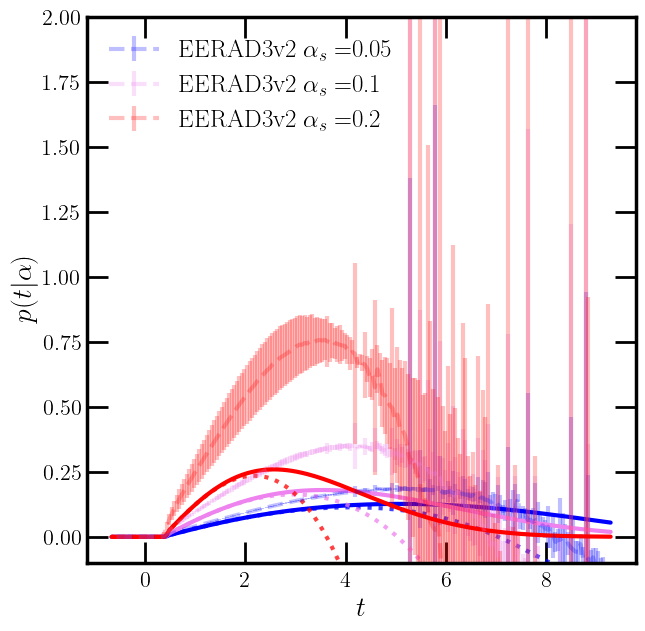

In [5]:
if dist in ["thrust"]:
    data_true_dict = None
    data_dict, t_bins, t_bin_centers = read_in_data_JAX(dist, m)
else:
    data_dict = {}
    data_true_dict = {}
    alphas = np.arange(.005, .325, 0.001)
    t_bins = jnp.linspace(0, 10, 201)
    t_bin_centers = (t_bins[1:] + t_bins[:-1])/2

    for a in alphas:
        y_data = get_pdf_toy_JAX(a, dist, t_bin_centers, m)
        y_true_data = get_pdf_toy_JAX(a, dist, t_bin_centers, -1)
        data_dict[a] = np.reshape(y_data, (-1, 1)), np.reshape(0.001 * jnp.ones_like(y_data), (-1, 1))
        data_true_dict[a] = np.reshape(y_true_data, (-1, 1)), np.reshape(0.001 * jnp.ones_like(y_true_data), (-1, 1))


x_bin_centers = jnp.exp(-t_bin_centers)

alpha_keys = np.array(list(data_dict.keys()))
alpha_keys_float = list(data_dict.keys())

t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)

ALPHA_MAX = 0.4
# alpha_keys_float = alpha_keys_float[alpha_keys <= ALPHA_MAX]
alpha_keys = alpha_keys[alpha_keys <= ALPHA_MAX]

# Keys of interest
keys = np.array([0.05, 0.1, 0.2,])

# Find the keys in the list closest to these values (to deal with floating point errors)
for (k, key) in enumerate(keys):

    closest_key = alpha_keys_float[np.argmin(np.abs(key - alpha_keys))]
    keys[k] = closest_key


# Make an array of ys and yerrs so we dont have to keep the dictionary around
ys = []
yerrs = []
for key in alpha_keys:
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    # clamp yerr by its nonzero minimum

    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
    
    ys.append(y)
    yerrs.append(yerr)

ys = jnp.array(ys)
yerrs = jnp.array(yerrs)

ys_xs = ys / x_bin_centers
yerrs_xs = yerrs / x_bin_centers


# Make a plot of the data 

if use_newplot:
    fig, ax = newplot("full")
else: 
    fig, ax = plt.subplots(1, 1)
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]


    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)

    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

    if data_true_dict:
        y_true, _ = data_true_dict[key]
        plt.plot(t_bin_centers, y_true,  color = darkcolors[k], ls = "-",label = r"True $\alpha_s = $" + f"{key}")


    # plt.plot(t_bin_centers, q_taylor_vals[k] / q_vals[k], color = colors[k], alpha = 0.75, ls = "-.")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")



# Loss and Training

In [6]:
# Set up the loss as a function of the parameters

loss_epsilon = 0

# Weighted MSE
@jax.jit
def loss_function(params, alphas, ys, yerrs):


    # x_bin_centers = jnp.exp(-t_bin_centers)
    # y_preds = jnp.nan_to_num(QM_ANSATZ(t_bin_centers, alphas, params))
    # return jnp.mean(jnp.nan_to_num((y_preds / x_bin_centers - ys_xs)**2 /(yerrs_xs**2 + loss_epsilon))) / 2



    y_preds = jnp.nan_to_num(QM_ANSATZ(t_bin_centers, alphas, params))
    mean_errors = jnp.mean(yerrs)
    y_errs_rescaled = yerrs / mean_errors

    return jnp.mean(jnp.nan_to_num((y_preds - ys)**2 /(y_errs_rescaled**2 + loss_epsilon))) / 2


print("Initial Loss: ", loss_function(params, alpha_keys, ys, yerrs))


Initial Loss:  270.58963


### Projector

Function to make sure that the polynomial's final coefficients always have the correct sign, and if freezing is on, keep the original parameters

In [7]:
@jax.jit
def project(params, epoch):

    # Get the signs right
    g_star = params["g_star"]
    g_coeffs = params["g_coeffs"]
    thetas = params["thetas"]
    thetas_coeffs = params["thetas_coeffs"]
    betas = params["betas"]
    betas_coeffs = params["betas_coeffs"]
    betas_pos = params["betas_positive"]


    g_star = g_star.at[0, -1].set(-jnp.abs(g_star[0, -1]))
    g_coeffs = g_coeffs.at[0, -1].set(-jnp.abs(g_coeffs[0, -1]))

    # Clip beta
    betas = jnp.clip(betas, beta_limits[0], beta_limits[1])
    betas_coeffs = jnp.clip(betas_coeffs, beta_limits[0], beta_limits[1])
    betas_pos = jnp.clip(betas_pos, beta_limits[0], beta_limits[1])

    # betas = beta_limits[0] + jnp.ones_like(betas) * epoch * (beta_limits[1] - beta_limits[0])
    # betas_coeffs = beta_limits[0] + jnp.ones_like(betas_coeffs) * epoch * (beta_limits[1] - beta_limits[0])

    g_coeffs = g_coeffs.at[m-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = thetas_coeffs.at[m-mstar:,].set(-1)  # Current order doesn't count


    # Restore the original parameters if frozen
    if freeze_previous_order and m > 1:

        g_coeffs_init = original_params["g_coeffs"]
        g_star_init = original_params["g_star"]
        thetas_init = original_params["thetas"]
        thetas_coeffs_init = original_params["thetas_coeffs"]
        betas_init = original_params["betas"]
        betas_coeffs_init = original_params["betas_coeffs"]
        betas_pos_init = original_params["betas_positive"]

        g_star = g_star.at[:-1].set(g_star_init[:-1])
        g_coeffs = g_coeffs.at[:-1-mstar].set(g_coeffs_init[:-1-mstar])
        thetas = thetas.at[:-1].set(thetas_init[:-1])
        thetas_coeffs = thetas_coeffs.at[:-1-mstar].set(thetas_coeffs_init[:-1-mstar])
        betas = betas.at[:-1].set(betas_init[:-1])
        betas_coeffs = betas_coeffs.at[:-1-mstar].set(betas_coeffs_init[:-1-mstar])
        betas_pos = betas_pos.at[:-1].set(betas_pos_init[:-1])



    params["g_star"] = g_star
    params["g_coeffs"] = g_coeffs
    params["thetas"] = thetas
    params["thetas_coeffs"] = thetas_coeffs
    params["betas"] = betas
    params["betas_coeffs"] = betas_coeffs
    params["betas_positive"] = betas_pos


    return params

### BOGO Initializer

In [8]:
bogo_epochs = 5000

best_loss = loss_function(params, alpha_keys, ys, yerrs)
best_params = params.copy()

best_params_log = [best_params,]
losses = [np.nan,]

if bogo_init:
    counter = 0
    for epoch in range(bogo_epochs):

        scale = (bogo_epochs - epoch) / bogo_epochs

        loss = loss_function(params, alpha_keys, ys, yerrs)
        if loss < best_loss:
            best_loss = loss
            best_params = copy.deepcopy(params)
            counter += 1

        else:

            # Initialize params
            jax_key, subkey1, subkey2, subkey3 = jax.random.split(jax_key, 4)

            g_star = np.random.normal(loc = best_params["g_star"], size = params["g_star"].shape, scale =  1/(np.sqrt(counter) + 1) * scale / 10) 
            g_coeffs = np.random.normal(loc = best_params["g_coeffs"], size = params["g_coeffs"].shape, scale =  1/(np.sqrt(counter) + 1) * scale / 10 )  
            g_coeffs[m-mstar:,:] = 0 # Current order doesn't count

            # # Choose signs nicely
            # for ni in range(g_star.shape[1]):

            #     if n % 2 == 0:
            #         g_star[:,n] = np.abs(g_star[:,n])
            #         g_coeffs[:,n] = np.abs(g_coeffs[:,n])
            #     else:
            #         g_star[:,n] = -np.abs(g_star[:,n])
            #         g_coeffs[:,n] = -np.abs(g_coeffs[:,n])


            thetas = params["thetas"]
            thetas = np.random.normal(loc = best_params["thetas"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10) 

            thetas_coeffs = params["thetas_coeffs"]
            thetas_coeffs = np.random.normal(loc = best_params["thetas_coeffs"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10) 

            betas = params["betas"]
            betas = np.random.normal(loc = best_params["betas"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10) 

            betas_coeffs = params["betas_coeffs"]
            betas_coeffs = np.random.normal(loc = best_params["betas_coeffs"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10)

            betas_positive = params["betas_positive"]
            betas_positive = np.random.normal(loc = best_params["betas_positive"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10)

            params = {
                "g_star" : jnp.array(g_star),
                "g_coeffs" : jnp.array(g_coeffs),
                "thetas" : jnp.array(thetas),
                "thetas_coeffs" : jnp.array(thetas_coeffs),
                "betas" : jnp.array(betas),
                "betas_coeffs" : jnp.array(betas_coeffs),
                "betas_positive" : jnp.array(betas_positive)
            }

            # Make sure params are physical
            params = project(params, 0)

        print("BOGO Epoch", epoch, "Loss =", loss, "Best Loss =", best_loss, "Counter =", counter)

        best_params_log.append(best_params)
        losses.append(best_loss)

params = best_params.copy()
print(params)



BOGO Epoch 0 Loss = 270.58963 Best Loss = 270.58963 Counter = 0
BOGO Epoch 1 Loss = 253.92014 Best Loss = 253.92014 Counter = 1
BOGO Epoch 2 Loss = 253.92014 Best Loss = 253.92014 Counter = 1
BOGO Epoch 3 Loss = 183.9112 Best Loss = 183.9112 Counter = 2
BOGO Epoch 4 Loss = 183.9112 Best Loss = 183.9112 Counter = 2
BOGO Epoch 5 Loss = 141.56609 Best Loss = 141.56609 Counter = 3
BOGO Epoch 6 Loss = 141.56609 Best Loss = 141.56609 Counter = 3
BOGO Epoch 7 Loss = 128.39795 Best Loss = 128.39795 Counter = 4
BOGO Epoch 8 Loss = 128.39795 Best Loss = 128.39795 Counter = 4
BOGO Epoch 9 Loss = 125.63784 Best Loss = 125.63784 Counter = 5
BOGO Epoch 10 Loss = 125.63784 Best Loss = 125.63784 Counter = 5
BOGO Epoch 11 Loss = 126.61521 Best Loss = 125.63784 Counter = 5
BOGO Epoch 12 Loss = 125.51545 Best Loss = 125.51545 Counter = 6
BOGO Epoch 13 Loss = 125.51545 Best Loss = 125.51545 Counter = 6
BOGO Epoch 14 Loss = 154.51447 Best Loss = 125.51545 Counter = 6
BOGO Epoch 15 Loss = 125.401596 Best Lo

KeyboardInterrupt: 

Text(0.5, 0, 'epochs')

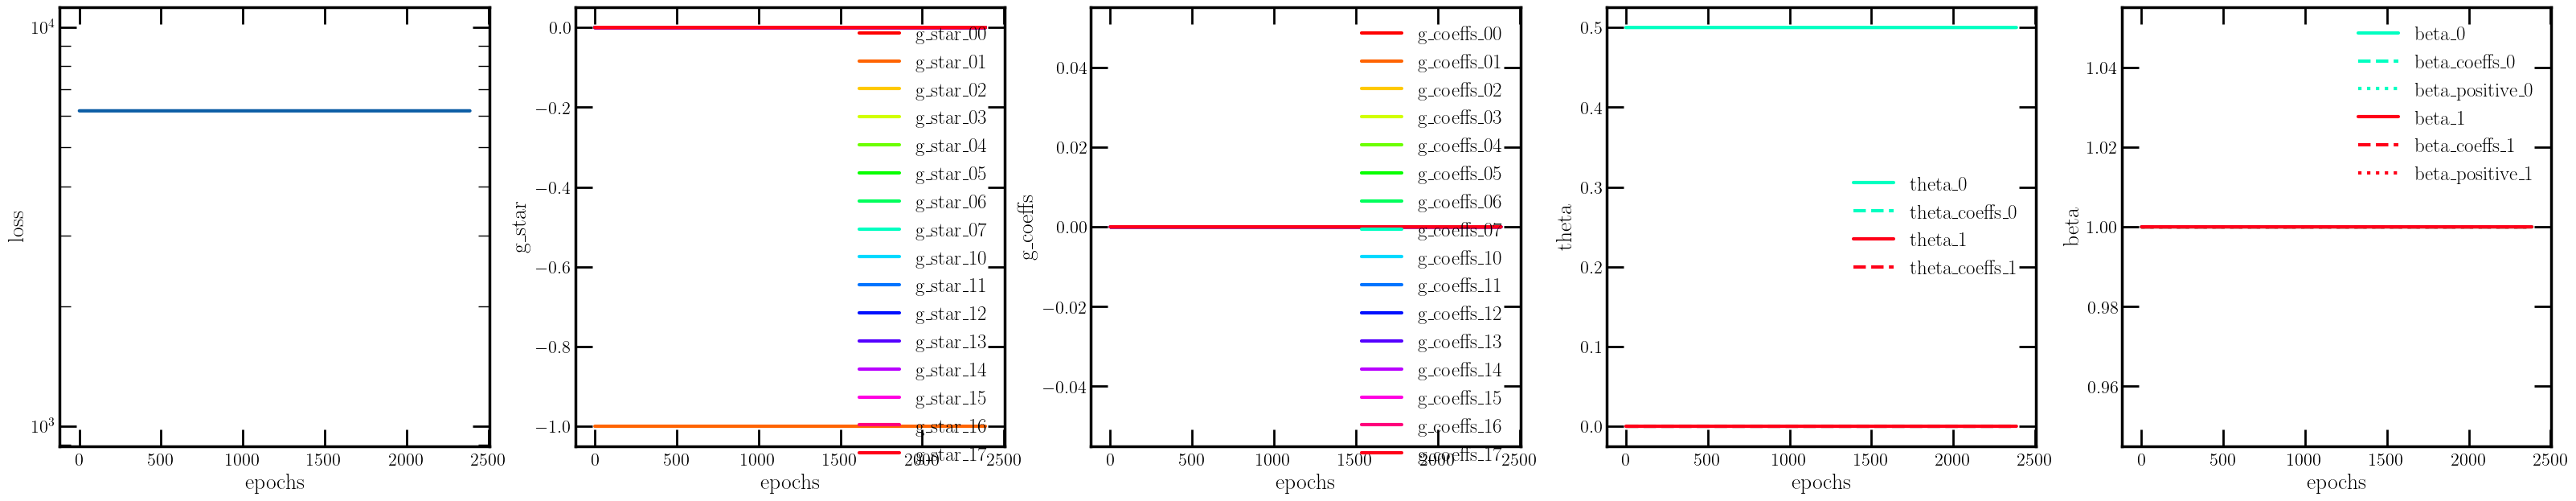

In [ ]:
if use_newplot:
    fig, ax = newplot("full", width = 8 * 5, subplot_array=(1, 5))
else: 
    fig, ax = plt.subplots(1, 5, figsize = (20, 2))
    


losses = np.array(losses)
g_star_log = np.array([b["g_star"] for b in best_params_log])
g_coeffs_log = np.array([b["g_coeffs"] for b in best_params_log])
thetas_log = np.array([b["thetas"] for b in best_params_log])
betas_log = np.array([b["betas"] for b in best_params_log])
thetas_c_log = np.array([b["thetas_coeffs"] for b in best_params_log])
betas_c_log = np.array([b["betas_coeffs"] for b in best_params_log])
betas_p_log = np.array([b["betas_positive"] for b in best_params_log])


color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)



ax[0].plot(losses)
ax[0].set_yscale("log")

for mi in range(g_star_log.shape[1]):


    for ni in range(g_star_log.shape[2]):

        c = next(color)

        ax[1].plot(g_star_log[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
        ax[2].plot(g_coeffs_log[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")

    ax[3].plot(thetas_log[:,mi], label = f"theta_{mi}", color = c)
    ax[4].plot(betas_log[:,mi], label = f"beta_{mi}", color = c)
    ax[3].plot(thetas_c_log[:,mi], label = f"theta_coeffs_{mi}", ls = "--", color = c)
    ax[4].plot(betas_c_log[:,mi], label = f"beta_coeffs_{mi}", ls = "--", color = c)
    ax[4].plot(betas_p_log[:,mi], label = f"beta_positive_{mi}", ls = ":", color = c)


ax[0].set_ylabel("loss")
ax[0].set_xlabel("epochs")

ax[1].legend()
ax[1].set_ylabel("g_star")
ax[1].set_xlabel("epochs")

ax[2].legend()
ax[2].set_ylabel("g_coeffs")
ax[2].set_xlabel("epochs")

ax[3].legend()
ax[3].set_ylabel("theta")
ax[3].set_xlabel("epochs")


ax[4].legend()
ax[4].set_ylabel("beta")
ax[4].set_xlabel("epochs")


### Real Training

Note due to compilation, epoch 1 should take a long time, but every subsequent epoch should be faster

In [ ]:
params = best_params.copy()

  0%|          | 0/50000 [00:00<?, ?it/s]

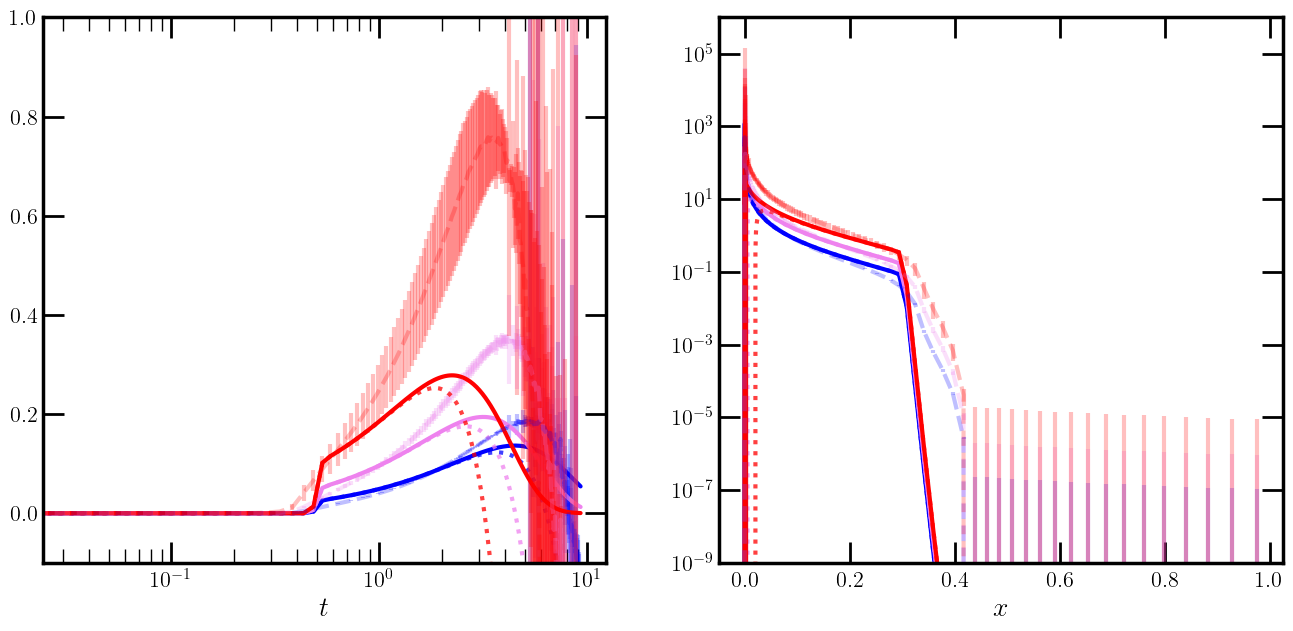

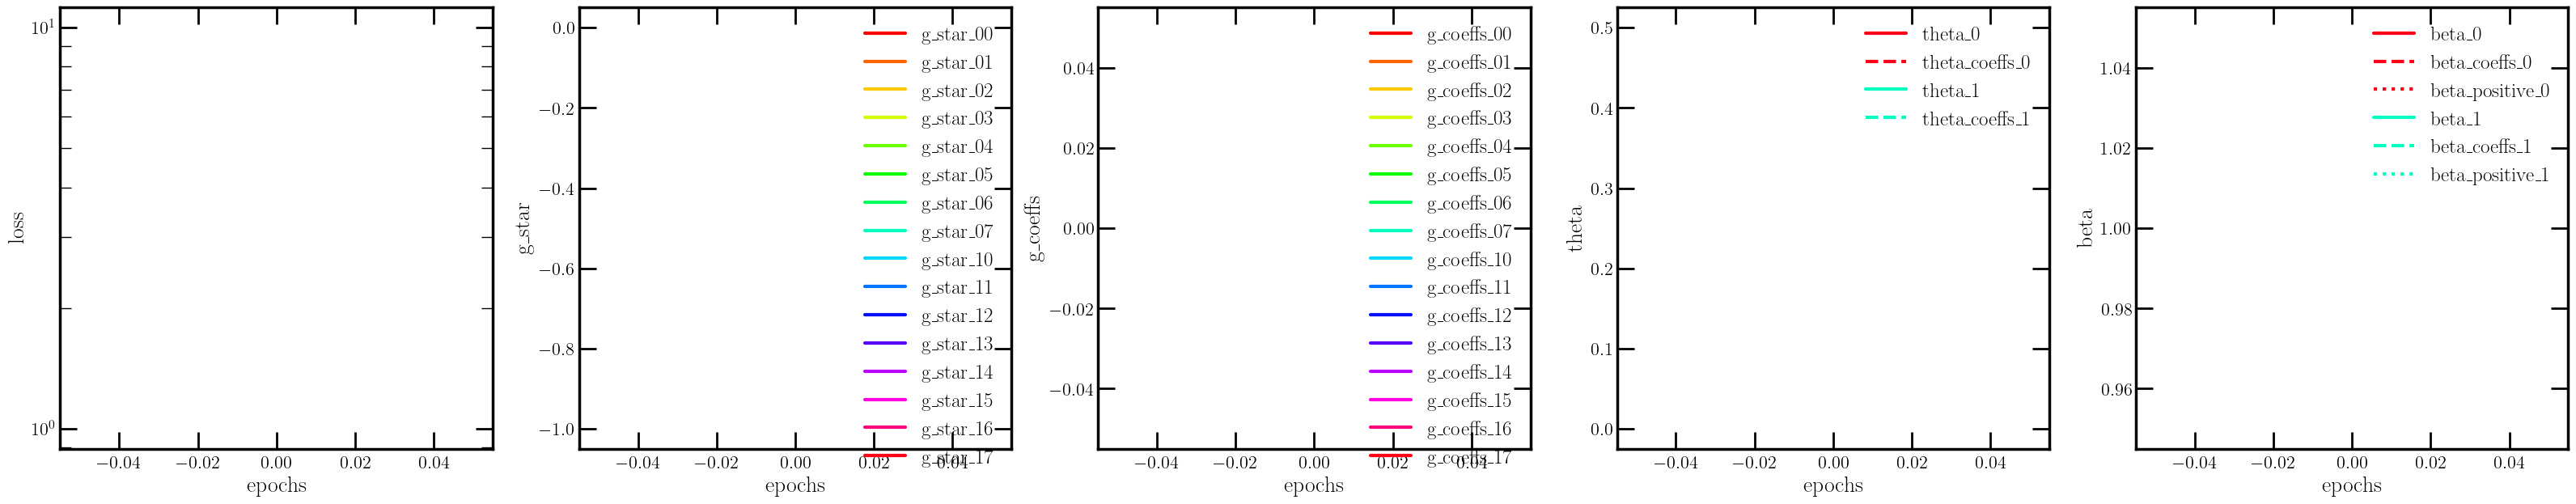

 5.6305e+04:   0%|          | 156/50000 [00:24<43:57, 18.90it/s]  

In [ ]:
# Initialize Optimizer
opt = optax.adamw(lr * 10 , weight_decay= weight_decay)
opt_state = opt.init(params)

# Initialize logs
losses = []
params_log = []
params_log.append(params)
g_coeffs_log = [params["g_coeffs"]]
g_star_log = [params["g_star"]]
thetas_log = [params["thetas"]]
betas_log = [params["betas"]]
thetas_c_log = [params["thetas_coeffs"]]
betas_c_log = [params["betas_coeffs"]]
betas_p_log = [params["betas_positive"]]


@jax.jit
def train_step(epoch, params, opt_state, random_key):
    
    # Boilerplate, in case we need random numbers
    key, subkey = jax.random.split(random_key)


    # Batch stuff
    if random_batch:
        alphas = jax.random.choice(key, alpha_keys, (batch_size,))
        y_batch = jax.random.choice(key, ys, (batch_size,))
        yerrs_batch = jax.random.choice(key, yerrs, (batch_size,))
    else:
        alphas = alpha_keys
        y_batch = ys
        yerrs_batch = yerrs

    # Get the gradients
    loss, grad_loss = jax.value_and_grad(loss_function)(params, alphas, y_batch, yerrs_batch)


    # Jax Grad Descent stuff
    updates, opt_state = opt.update(grad_loss, opt_state, params=params)
    params = optax.apply_updates(params, updates)

    

    # Save the random key for the seed for the next epoch
    return params, opt_state, loss, subkey

# Loop
epochs_tqdm = tqdm(range(epochs))
for epoch in epochs_tqdm:



    if epoch % 1000 == 0:
        if use_newlot:
            fig, ax = newplot("full", subplot_array=(1,2), width=8 * 2)
        else: 
            fig, ax = plt.subplots(1, 2, figsize = (8, 2))
        q_vals = Q_ANSATZ(t_bin_centers, keys, params)
        q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

        for (k, key) in enumerate(keys):
            y, yerr = data_dict[key]
            y = y[:,0]
            yerr = yerr[:,0]
            min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
            yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
            ax[0].errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
            ax[0].plot(t_bin_centers, q_vals[k], color = colors[k])
            ax[0].plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

            ax[1].errorbar(x_bin_centers / mult_factor, mult_factor * y / x_bin_centers, mult_factor * yerr / x_bin_centers, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
            ax[1].plot(x_bin_centers / mult_factor, mult_factor *  q_vals[k]  /x_bin_centers, color = colors[k])
            ax[1].plot(x_bin_centers / mult_factor, mult_factor * q_taylor_vals[k]  /x_bin_centers, color = colors[k], alpha = 0.75, ls = "dotted")

            if data_true_dict:
                y_true, _ = data_true_dict[key]
                ax[0].plot(t_bin_centers, y_true,  color = darkcolors[k], ls = "-",label = r"True $\alpha_s = $" + f"{key}")
                ax[1].plot(x_bin_centers / mult_factor, y_true[:,0] * mult_factor / x_bin_centers,  color = darkcolors[k], ls = "-",label = r"True $\alpha_s = $" + f"{key}")



        ax[0].set_xscale("log")
        ax[1].set_yscale("log")

        ax[0].set_ylim(-0.1, 1e0)
        ax[1].set_ylim(1e-9, 1e6)

        ax[0].set_xlabel(r"$t$")
        ax[1].set_xlabel(r"$x$")


        # plt.xlim(0, 1)
        plt.show()


        if use_newplot:
            fig, ax = newplot("full", width = 8 * 5, subplot_array=(1, 5))
        else: 
            fig, ax = plt.subplots(1, 5, figsize = (20, 2))
            
        

        losses_ = np.array(losses)
        g_star_log_ = np.array(g_star_log)
        g_coeffs_log_ = np.array(g_coeffs_log)
        thetas_log_ = np.array(thetas_log)
        betas_log_ = np.array(betas_log)
        thetas_c_log_ = np.array(thetas_c_log)
        betas_c_log_ = np.array(betas_c_log)
        betas_p_log_ = np.array(betas_p_log)


        color = iter(
            cm.hsv(np.linspace(0, 1, g_coeffs_log_.shape[1] * g_coeffs_log_.shape[2]))
        )


        ax[0].plot(losses_)
        ax[0].set_yscale("log")

        for mi in range(g_star_log_.shape[1]):

            ax[3].plot(thetas_log_[:,mi], label = f"theta_{mi}", color = c)
            ax[4].plot(betas_log_[:,mi], label = f"beta_{mi}", color = c)

            ax[3].plot(thetas_c_log_[:,mi], label = f"theta_coeffs_{mi}", color = c, ls = "--")
            ax[4].plot(betas_c_log_[:,mi], label = f"beta_coeffs_{mi}", color = c, ls = "--")

            ax[4].plot(betas_p_log_[:,mi], label = f"beta_positive_{mi}", ls = ":", color = c)


            for ni in range(g_star_log_.shape[2]):

                c = next(color)

                ax[1].plot(g_star_log_[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
                ax[2].plot(g_coeffs_log_[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")

        ax[0].set_ylabel("loss")
        ax[0].set_xlabel("epochs")

        ax[1].legend()
        ax[1].set_ylabel("g_star")
        ax[1].set_xlabel("epochs")

        ax[2].legend()
        ax[2].set_ylabel("g_coeffs")
        ax[2].set_xlabel("epochs")

        ax[3].legend()
        ax[3].set_ylabel("theta")
        ax[3].set_xlabel("epochs")


        ax[4].legend()
        ax[4].set_ylabel("beta")
        ax[4].set_xlabel("epochs")
        plt.show()

    # Train Step
    params, opt_state, loss, jax_key = train_step(epoch, params, opt_state, jax_key)


    # Project the params to make them physical
    params = project(params, epoch / epochs)
    # print(params)

    losses.append(loss)
    g_star_log.append(params['g_star'])
    g_coeffs_log.append(params['g_coeffs'])
    thetas_log.append(params['thetas'])
    betas_log.append(params["betas"])
    thetas_c_log.append(params["thetas_coeffs"])
    betas_c_log.append(params["betas_coeffs"])
    betas_p_log.append(params["betas_positive"])
    params_log.append(params)


    epochs_tqdm.set_description(f"{losses[-1].item() : .4e}")
    # print(g_coeffs_log[-1])
    # print(g_star_log[-1])
    # print(thetas_log[-1])



In [ ]:

with open(f"output_JAX/{name}_params.pkl", "wb") as f:
    pickle.dump(params, f)

with open(f"output_JAX/{name}_params_history.pkl", "wb") as f:
    pickle.dump(params_log, f)

with open(f"output_JAX/{name}_loss_history.pkl", "wb") as f:
    pickle.dump(losses, f)

Text(0.5, 0, 'epochs')

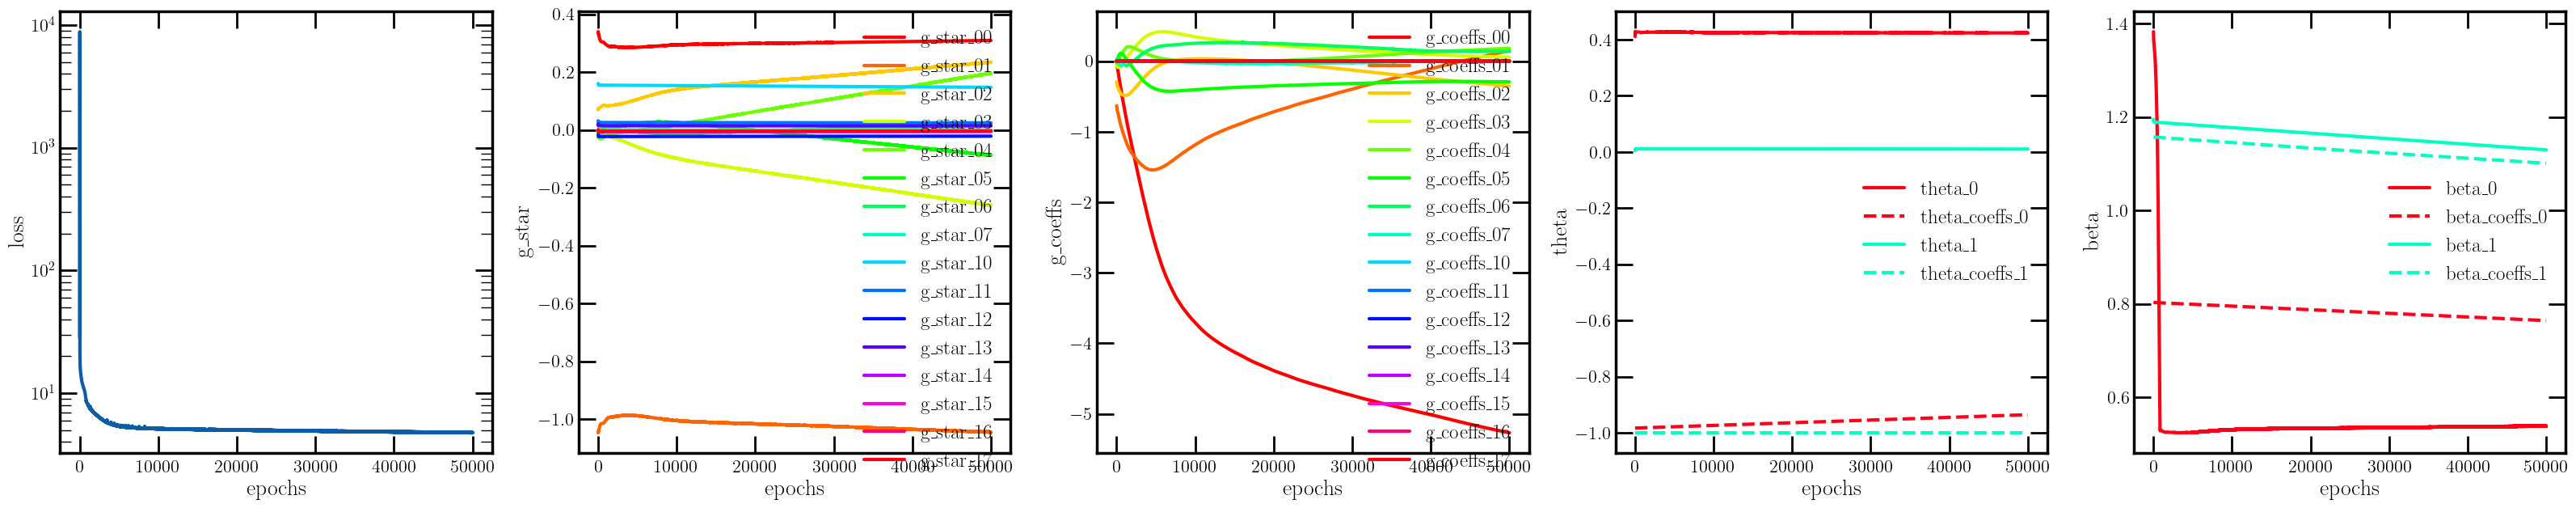

In [ ]:

if use_newplot:
    fig, ax = newplot("full", width = 8 * 5, subplot_array=(1, 5))
else: 
    fig, ax = plt.subplots(1, 5, figsize = (20, 2))
    


losses = np.array(losses)
g_star_log = np.array(g_star_log)
g_coeffs_log = np.array(g_coeffs_log)
thetas_log = np.array(thetas_log)
betas_log = np.array(betas_log)
thetas_c_log_ = np.array(thetas_c_log)
betas_c_log_ = np.array(betas_c_log)


color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)


ax[0].plot(losses)
ax[0].set_yscale("log")

for mi in range(g_star_log.shape[1]):

    ax[3].plot(thetas_log[:,mi], label = f"theta_{mi}", color = c)
    ax[4].plot(betas_log[:,mi], label = f"beta_{mi}", color = c)

    ax[3].plot(thetas_c_log_[:,mi], label = f"theta_coeffs_{mi}", color = c, ls = "--")
    ax[4].plot(betas_c_log_[:,mi], label = f"beta_coeffs_{mi}", color = c, ls = "--")

    for ni in range(g_star_log.shape[2]):

        c = next(color)

        ax[1].plot(g_star_log[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
        ax[2].plot(g_coeffs_log[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")

ax[0].set_ylabel("loss")
ax[0].set_xlabel("epochs")

ax[1].legend()
ax[1].set_ylabel("g_star")
ax[1].set_xlabel("epochs")

ax[2].legend()
ax[2].set_ylabel("g_coeffs")
ax[2].set_xlabel("epochs")

ax[3].legend()
ax[3].set_ylabel("theta")
ax[3].set_xlabel("epochs")


ax[4].legend()
ax[4].set_ylabel("beta")
ax[4].set_xlabel("epochs")


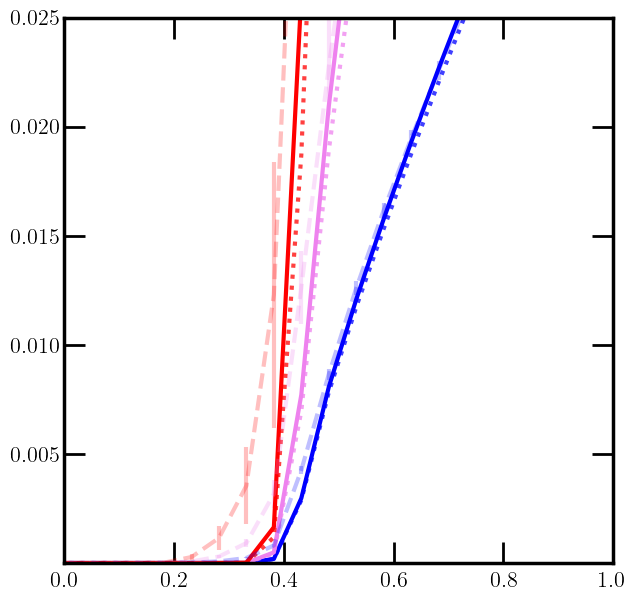

{'betas': Array([0.53841484, 1.1297716 ], dtype=float32), 'betas_coeffs': Array([0.76415145, 1.1009703 ], dtype=float32), 'betas_positive': Array([0.11477748, 0.        ], dtype=float32), 'g_coeffs': Array([[-5.2678719e+00,  1.4809258e-01, -3.5416576e-01,  5.6329444e-02,
         1.8315198e-01, -2.9335773e-01,  1.3752325e-01, -1.2728437e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],      dtype=float32), 'g_star': Array([[ 3.0943131e-01, -1.0454024e+00,  2.3423752e-01, -2.6063725e-01,
         1.9600154e-01, -8.7428212e-02,  1.9494155e-02, -4.4251072e-05],
       [ 1.4747562e-01,  2.4369154e-02, -2.1585526e-02,  1.3985543e-02,
        -4.9979473e-03, -4.0889760e-03, -4.0756203e-03, -4.0283203e-03]],      dtype=float32), 'thetas': Array([0.42374837, 0.01043988], dtype=float32), 'thetas_coeffs': Array([-0.93552023, -1.        ], dtype=float32)}


In [ ]:
if use_newplot:
    fig, ax = newplot("full"))
else: 
    fig, ax = plt.subplots(1,1)
    


params = params_log[-1]

# params = {'g_coeffs': jnp.array([[-1.4129587e+00, -8.3932149e-01, -3.6408892e-01,  2.1668930e-01,
#          9.2633456e-02, -8.7050162e-02, -1.0447601e-01, -1.3033234e-02,
#          1.0823050e-01, -2.7595865e-02],
#        [ 1.9706091e-02,  1.0751380e-01,  7.2292695e-03,  7.2420542e-03,
#          3.4468577e-03, -6.2232531e-05,  1.3756469e-05,  5.0528266e-05,
#          3.6526422e-04, -5.9835085e-05]]), 'g_star': jnp.array([[ 3.6294520e-01, -1.0979660e+00,  1.9972968e-01, -8.7971516e-02,
#         -3.1348750e-02,  4.8306610e-02,  7.9979207e-03, -3.1092776e-02,
#          1.3078115e-02, -1.0615622e-04],
#        [-1.5308211e+00, -1.4279670e+00, -6.4494938e-01, -4.9874373e-02,
#          3.3021158e-01,  1.8047714e-01,  3.7153810e-02,  1.6338695e-02,
#          7.4233182e-02, -8.4546432e-02]]), 'thetas': jnp.array([0.44273797, 0.53100968])}

q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.xlim(0, 1)
plt.ylim(0.000001, 0.025)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

print(params)


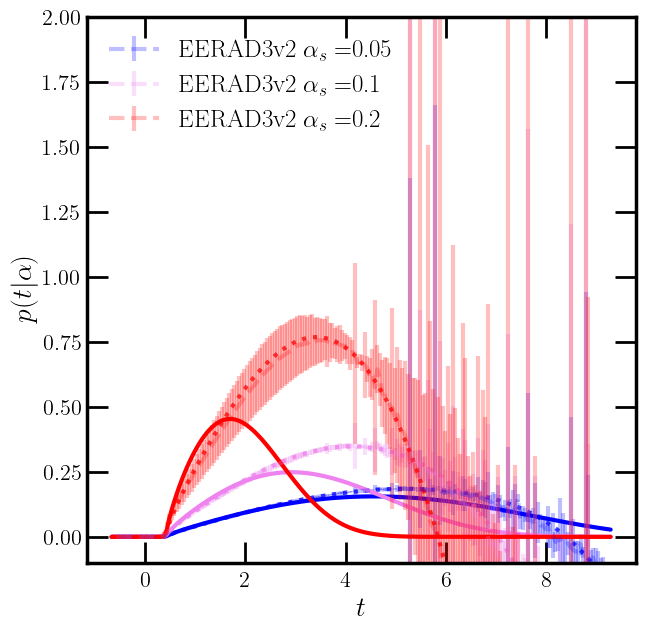

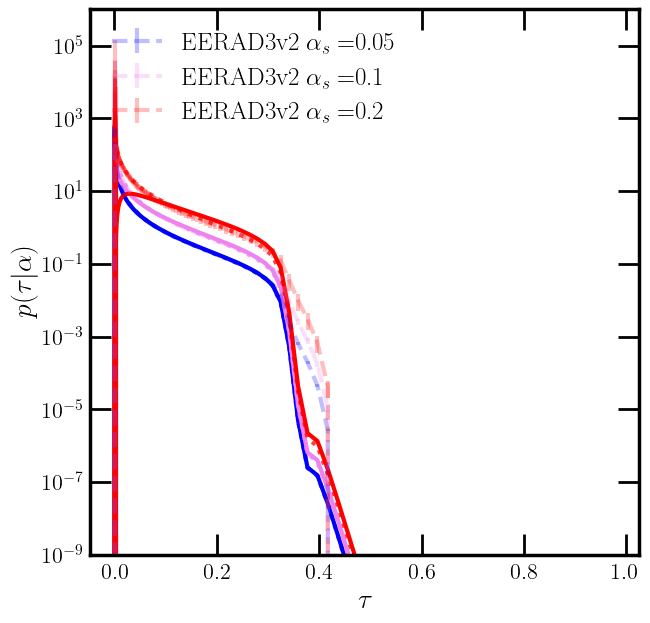

In [ ]:
# Make a plot of the data 
fig, ax = newplot("full")
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")






# x-version

# Make a plot of the data 
if use_newplot:
    fig, ax = newplot("full")
else: 
    fig, ax = plt.subplots(1, 1)
x_bin_centers = np.exp(-t_bin_centers) / mult_factor
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    plt.errorbar(x_bin_centers, y/ x_bin_centers, yerr / x_bin_centers, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(x_bin_centers, q_vals[k] / x_bin_centers, color = colors[k])
    plt.plot(x_bin_centers, q_taylor_vals[k] / x_bin_centers, color = colors[k], alpha = 0.75, ls = "dotted")

# plt.xlim(0, 0.5)
plt.yscale("log")
plt.ylim(1e-9, 1e6)
# plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau | \alpha)$")
plt.legend(loc = "upper left")
